Epoch 1/50


D:\My\CS\Hackothons\Intellihack\Intellihack_CodeCrafters_4\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
D:\My\CS\Hackothons\Intellihack\Intellihack_CodeCrafters_4\venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.1532 - val_loss: 0.0818
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0707 - val_loss: 0.0806
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0659 - val_loss: 0.0808
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0621 - val_loss: 0.0806
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0629 - val_loss: 0.0811
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0639 - val_loss: 0.0808
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0650 - val_loss: 0.0805
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0620 - val_loss: 0.0806
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0614 - val_loss: 0.0826
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0635 - val_loss: 0.0808
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0620 - val_loss: 0.0807
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0671 - val_l

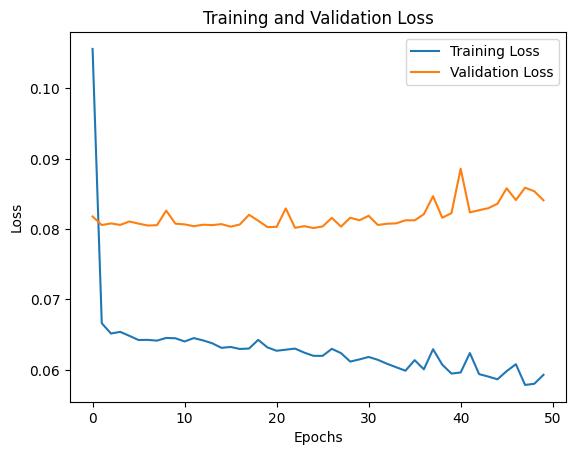

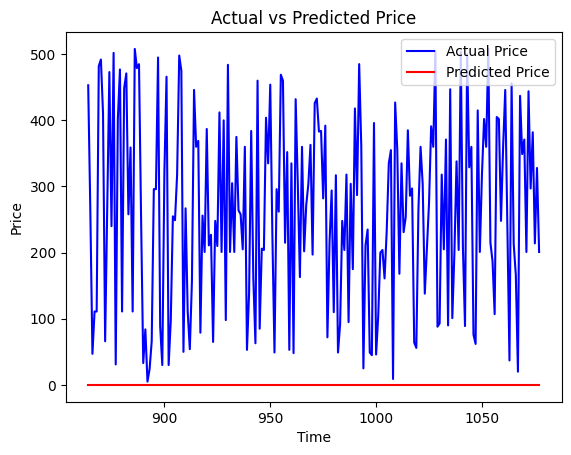

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load the preprocessed dataset (assuming you have already performed data preprocessing steps)
df = pd.read_csv('./Watches_Bags_Accessories.csv', encoding='windows-1252')

# Normalize the data
scaler = MinMaxScaler()

columns = ['Rating in Stars', 'Rating Count', 'Voucher', 'Current Price', 'Original Price']

label_encoder = LabelEncoder()

# Encode 'Category' column
df['Rating in Stars'] = label_encoder.fit_transform(df['Rating in Stars'])
df['Rating Count'] = label_encoder.fit_transform(df['Rating Count'])
df['Voucher'] = label_encoder.fit_transform(df['Voucher'])
df['Current Price'] = label_encoder.fit_transform(df['Current Price'])
df['Original Price'] = label_encoder.fit_transform(df['Original Price'])

scaled_data = scaler.fit_transform(df[columns].astype(float))

# Define the number of time steps (e.g., past 12 months) for LSTM input
n_steps = 12
X, y = [], []
for i in range(n_steps, len(df)):
    X.append(scaled_data[i - n_steps:i, :])
    y.append(scaled_data[i, 3])  # Assuming 'Current Price' is the target variable

X, y = np.array(X), np.array(y)

# Split data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test, y_train, y_test = X[:split_index], X[split_index:], y[:split_index], y[split_index:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=20, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred), 4)), y_pred), axis=1))[:, 3]  # Inverse scaling

mae = mean_absolute_error(df['Current Price'].iloc[split_index + n_steps:], y_pred)
mse = mean_squared_error(df['Current Price'].iloc[split_index + n_steps:], y_pred)
r2 = r2_score(df['Current Price'].iloc[split_index + n_steps:], y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Visualize actual vs predicted prices
plt.plot(df.index[split_index + n_steps:], df['Current Price'].iloc[split_index + n_steps:], label='Actual Price', color='blue')
plt.plot(df.index[split_index + n_steps:], y_pred, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Price')
plt.legend()
plt.show()
